In [76]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# requirements:
# python==3.10.0
# scanpy==1.10.1
# anndata==0.10.7
# pandas==2.1.4
# numpy==1.23.4
# matplotlib==3.8.2
# seaborn==0.13.2

def read_10x_tsv(path):
    """
    Read 10x tsv files into anndata object
    """
    adata = ad.read_csv(path, delimiter='\t')
    return adata

norm_gene_expression_path = '../data/fastq_pass.gene_expression.processed.tsv'
norm_transcript_expression_path = '../data/fastq_pass.transcript_expression.processed.tsv'
gene_expression_path = '../data/fastq_pass.gene_expression.counts.tsv'
transcript_expression_path = '../data/fastq_pass.transcript_expression.counts.tsv'
umis_per_bc_path = '../data/umis_per_barcode.tsv'

gene_expression = read_10x_tsv(gene_expression_path)
transcript_expression = read_10x_tsv(transcript_expression_path)
umi_count = pd.read_csv(umis_per_bc_path, sep='\t', header=None, names=['barcode', 'umis'])

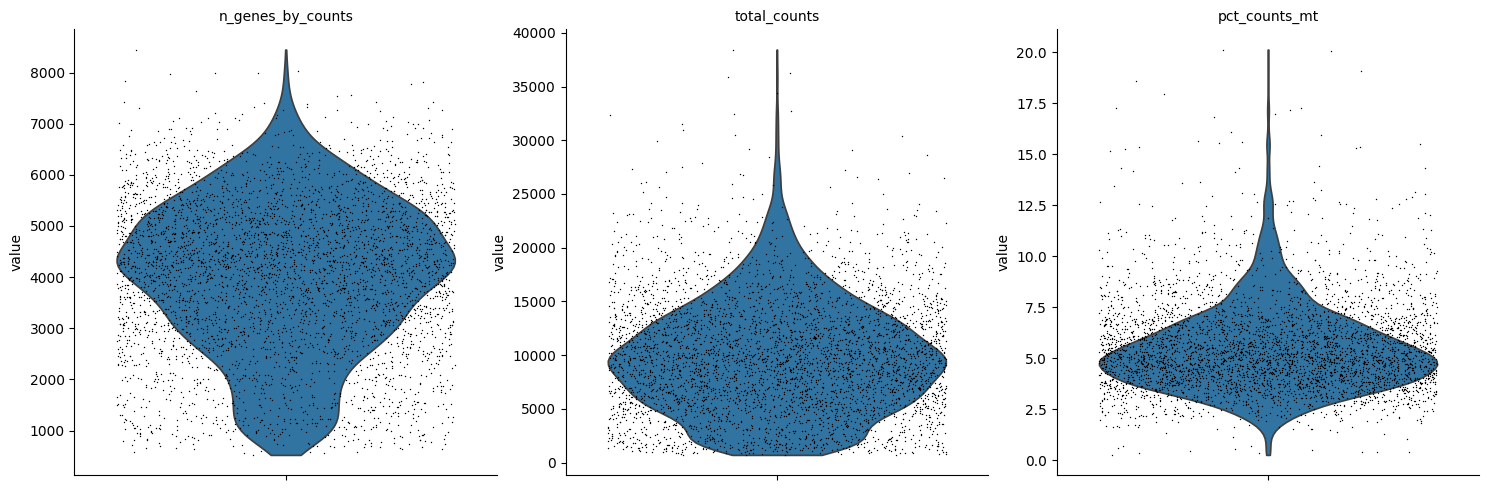

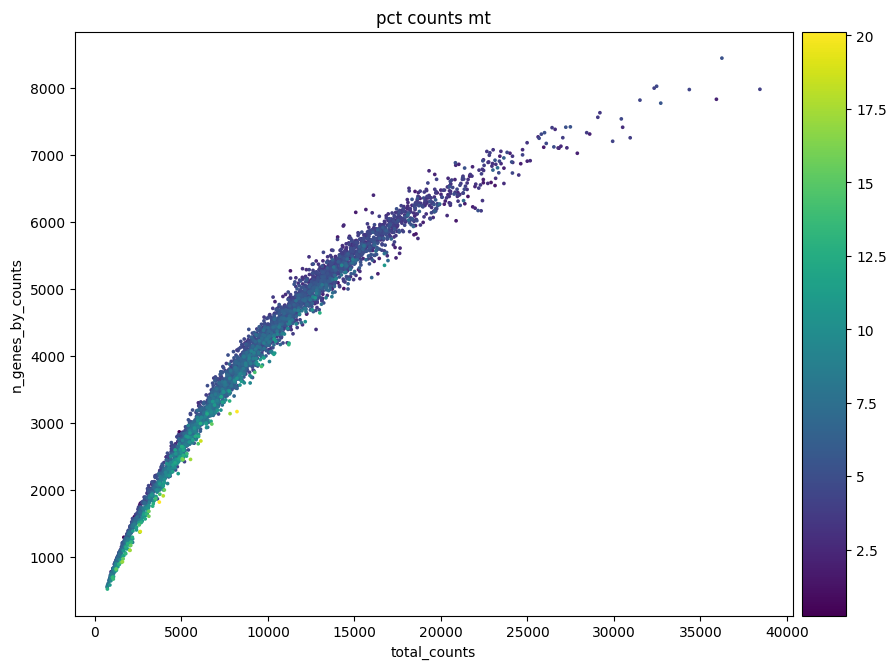

In [77]:
# QC
# Use either gene_expression or transcript_expression
adata = gene_expression.copy()
adata = adata.T

# mitochondrial genes, "mt-" or "Mt"
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["mt"] = adata.var["mt"] | adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

# Add umi counts observations to adata
adata.obs["umi_counts"] = umi_count.set_index("barcode").loc[adata.obs_names]["umis"]

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    scale="width",
    multi_panel=True,
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

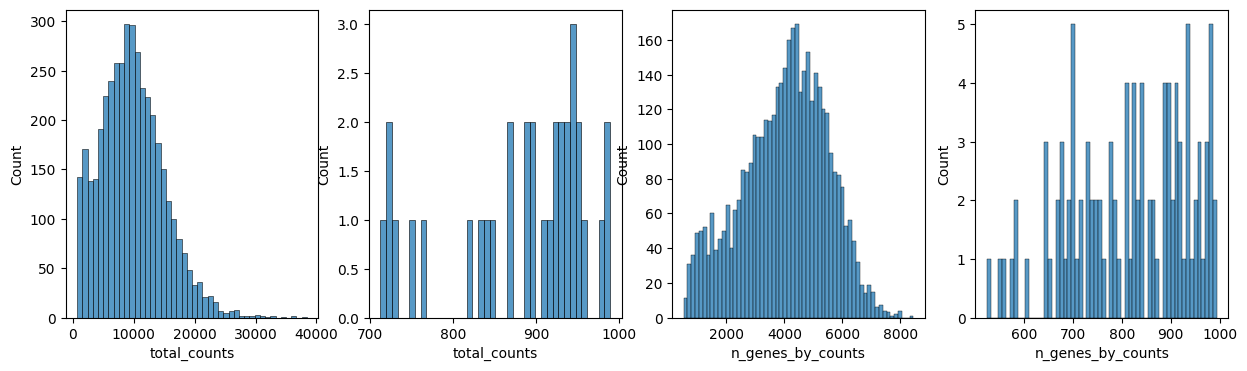

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 1000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [79]:

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", flavor="igraph", directed=False, resolution=0.4
)
adata.var["highly_variable"]

0610005C13Rik    False
0610009B22Rik    False
0610009E02Rik     True
0610009L18Rik    False
0610010K14Rik    False
                 ...  
mt-Nd3           False
mt-Nd4           False
mt-Nd4l           True
mt-Nd5            True
mt-Nd6            True
Name: highly_variable, Length: 22164, dtype: bool

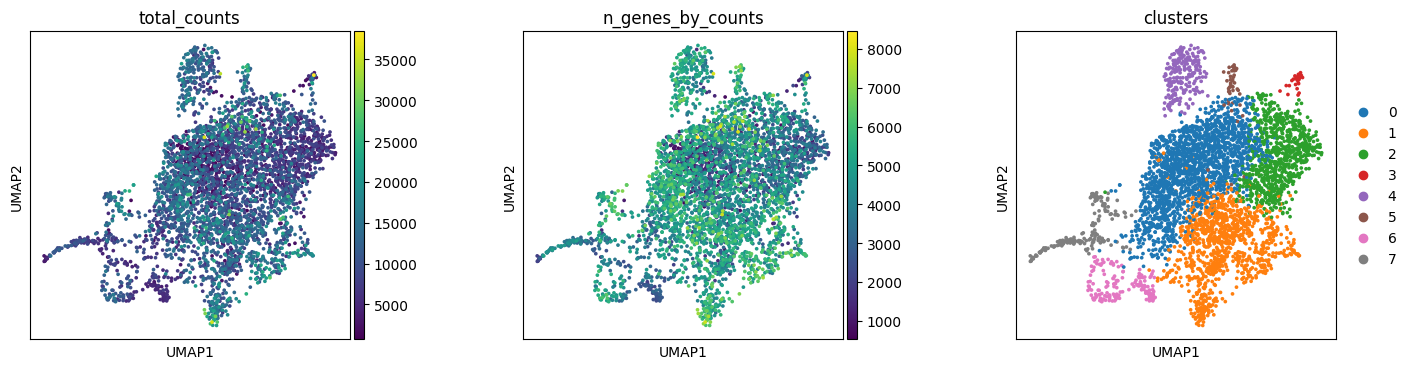

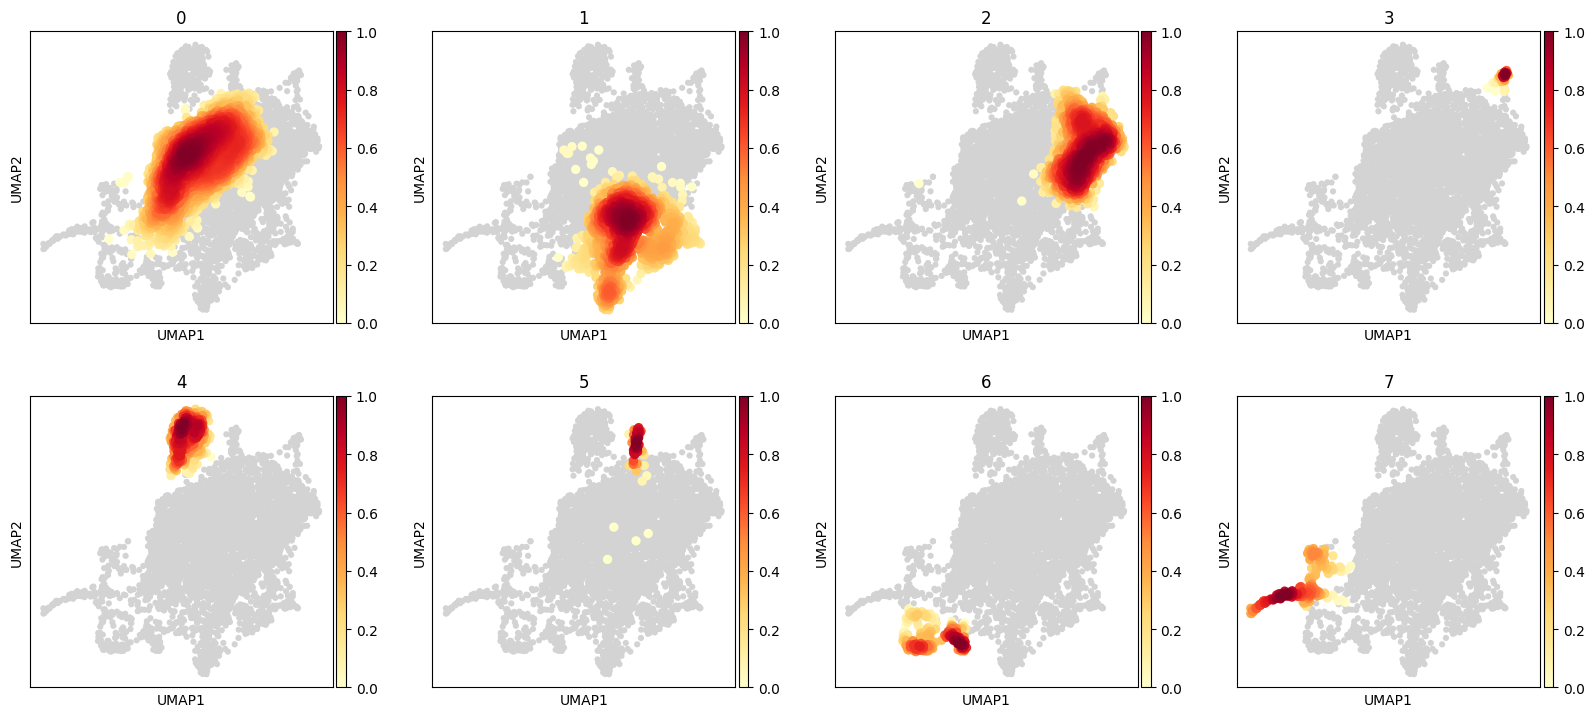

In [80]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)
sc.tl.embedding_density(adata, basis="umap", groupby="clusters")
sc.pl.embedding_density(adata, groupby="clusters", ncols=4)



AnnData object with n_obs × n_vars = 4195 × 22164
    obs: 'umi_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'clusters', 'umap_density_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'clusters', 'clusters_colors', 'umap_density_clusters_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


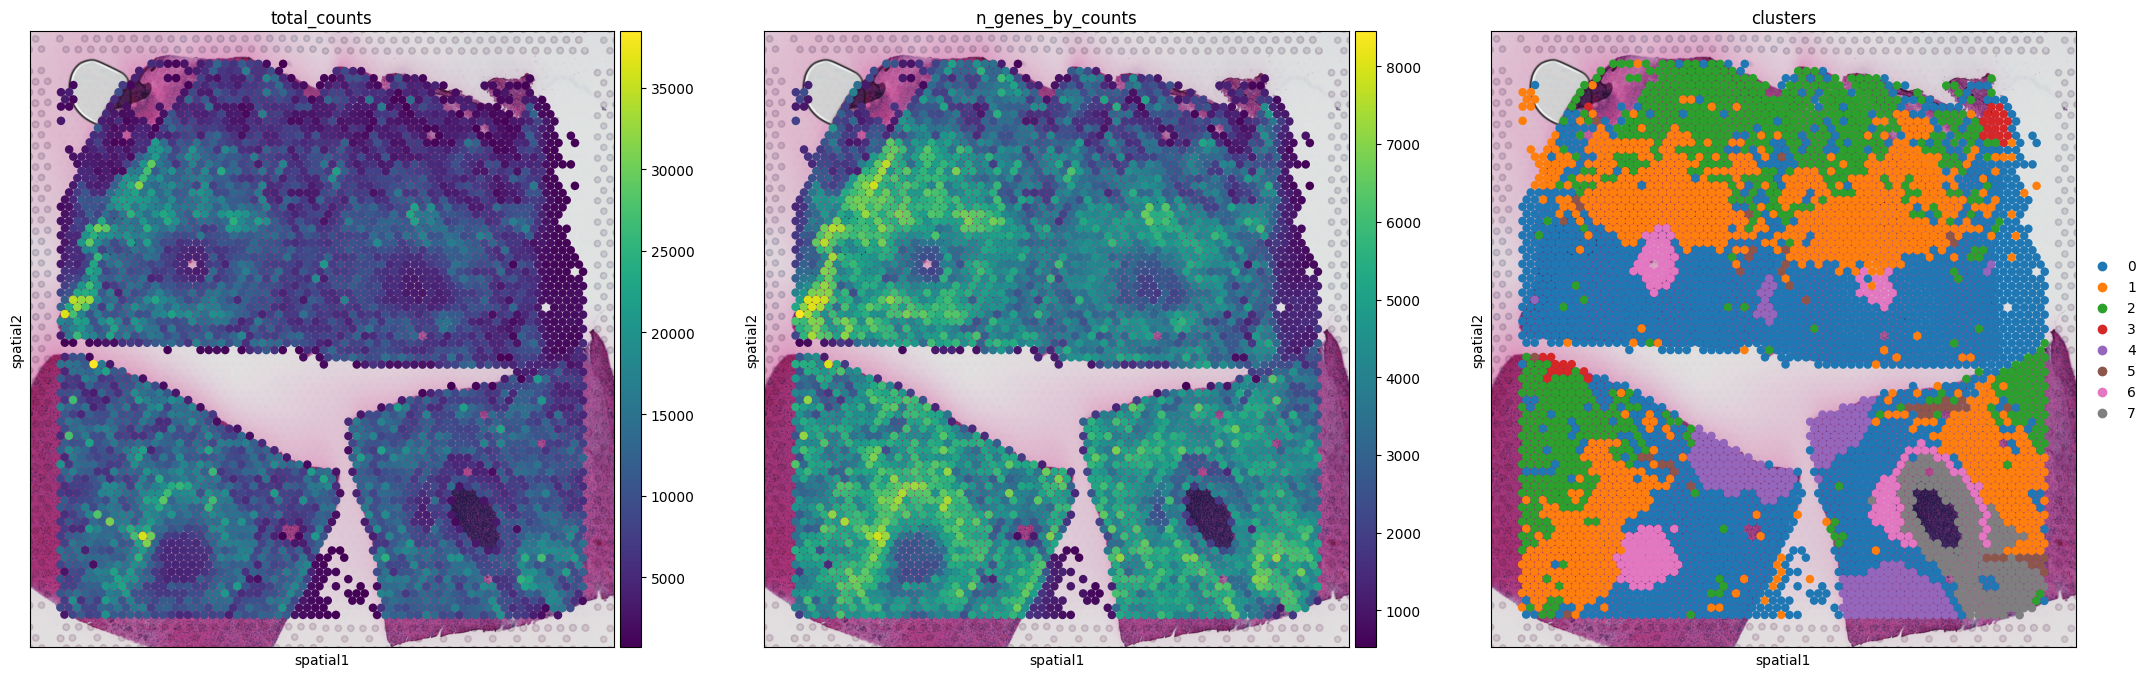

In [81]:


whitelist_f = "../data/fastq_pass.whitelist.tsv"
whitelist = pd.read_csv(whitelist_f, header=None, names=["barcode"])
image = "../data/spatial/tissue_hires_image.png"

# Load image as numpy array
from PIL import Image
img = Image.open(image)
img_d = np.array(img)

coordinates_f = "../data/spatial/tissue_positions_list.csv"
coordinates = pd.read_csv(coordinates_f, header=None, names=["barcode", "in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"])

# Sort coordinates by barcode or else this will not work
coordinates = coordinates.sort_values(by="barcode")  

# Remove the "-1" from the barcode
coordinates["barcode"] = coordinates["barcode"].str.split("-").str[0]

# Only keep coordinates which are found in adata
coordinates = coordinates[coordinates["barcode"].isin(adata.obs_names)]

print(adata)
spatial_key = "spatial"
library_id = "P25551A1"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": img_d}
adata.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 0.04245924,
    "spot_diameter_fullres": 377.4949302508056,
}
adata.obsm["spatial"] = coordinates[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values


plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts","n_genes_by_counts","clusters"], library_id=library_id, size=1.6, color_map="viridis")


In [82]:



# TEST ENSMUST00000133193 and ENSMUST00000080658 ++ -- Mbp (myelin basic protein) splice variants, shows same spatial pattern
# This will fail if you are using the gene expression matrix and not the transcript expression matrix
sc.pl.spatial(adata, img_key="hires", color=["ENSMUST00000133193","ENSMUST00000080658","ENSMUST00000152071",
                                             "ENSMUST00000142850", "ENSMUST00000153478","clusters"], size=1.5, ncols=3)


KeyError: 'Could not find key ENSMUST00000133193 in .var_names or .obs.columns.'

<Figure size 2673x1600 with 0 Axes>

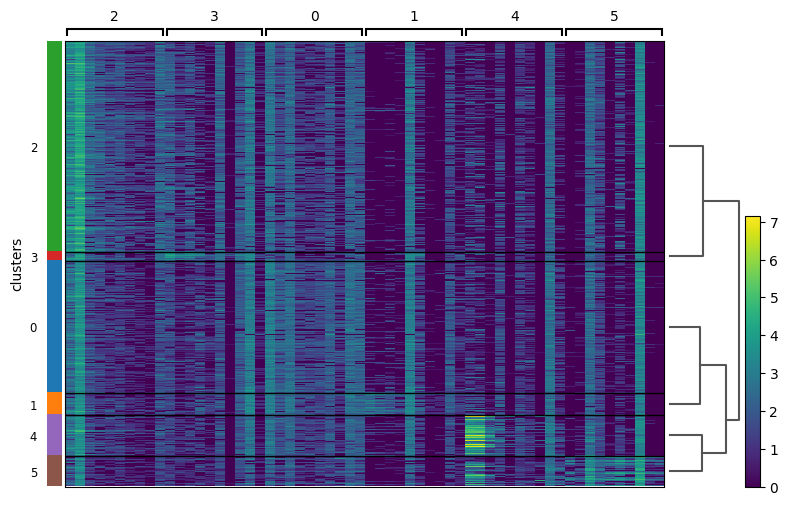

categories: 0, 1, 2, etc.
var_group_labels: 1, 2, 3, etc.


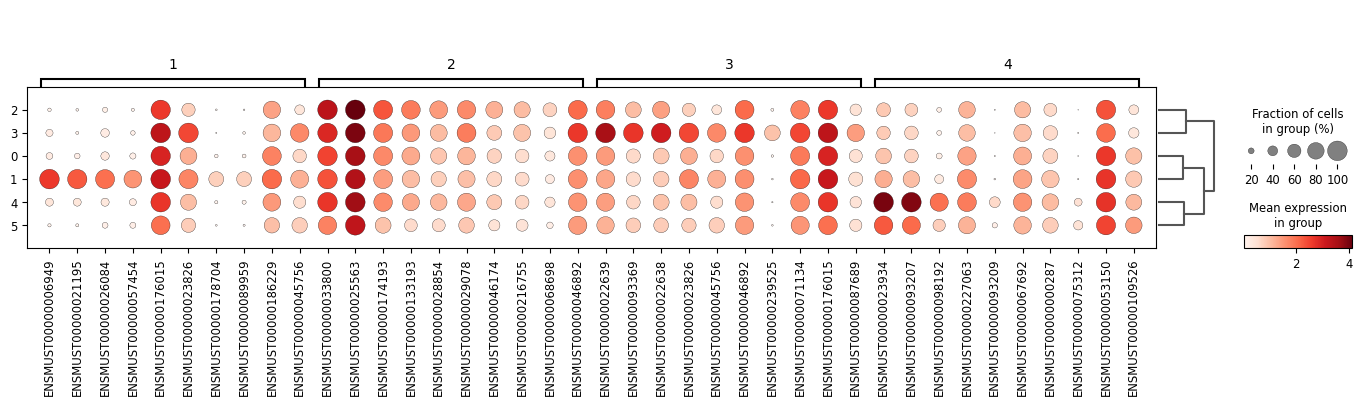

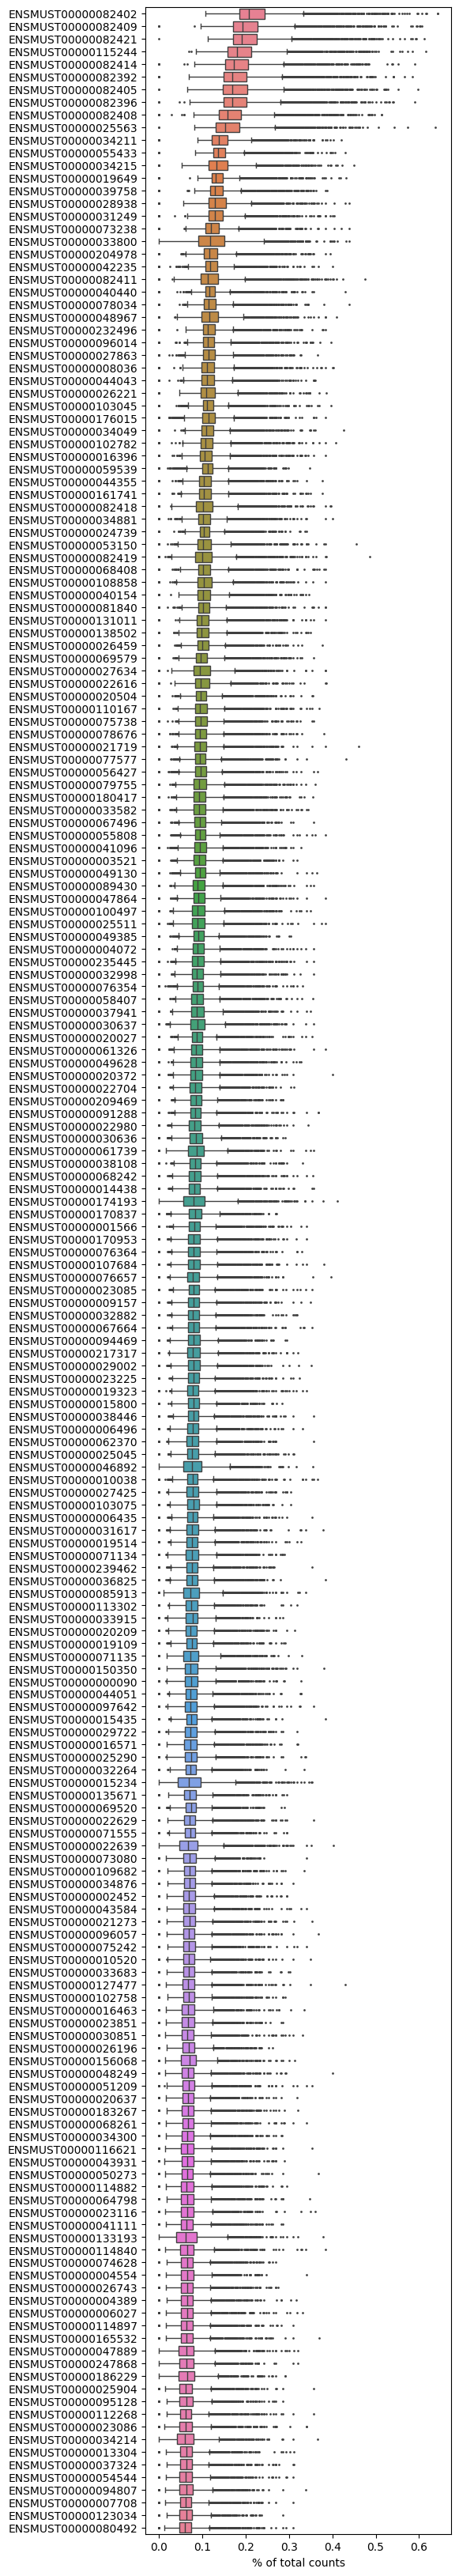

In [ ]:
# Gene rankings -- Not used

#sc.tl.rank_genes_groups(adata, groupby="clusters", method="t-test", n_genes=10)
#sc.tl.filter_rank_genes_groups(adata, min_fold_change=4)
#sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="clusters")
#sc.pl.rank_genes_groups_dotplot(adata, groups=["1","2","3","4"], n_genes=10, groupby="clusters")
#sc.pl.highest_expr_genes(adata, n_top=50)